In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np 

In [2]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

In [3]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cpu"):  # 計算が重いのでGPUを用いたい
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = torch.tensor(images[0].reshape(1, -1))
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = torch.tensor(images[i].reshape(1, -1)).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        E, V = torch.symeig(con_matrix, eigenvectors=True)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

zca = ZCAWhitening()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
zca.fit(trainset.data)
transform_train = transforms.Compose([
                                      transforms.RandomHorizontalFlip(p=1.0),
                                      transforms.RandomCrop(32, padding=(4, 4, 4, 4), padding_mode='constant'),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      ])
trainset.transform = transform_train
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)
transform = transforms.Compose([transforms.ToTensor()])
testset.transform = transform
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!
Files already downloaded and verified


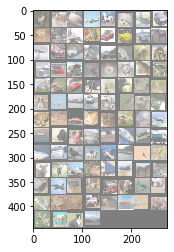

 frog horse  ship plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # [-1,1] を [0,1] へ戻す(正規化解除)
    npimg = img.numpy()  # torch.Tensor から numpy へ変換
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # チャンネルを最後に並び変える((C,X,Y) -> (X,Y,C))
    plt.show()  # 表示


# 訓練用画像を取得する
# pythonでは順番にデータを取得する際にイテレータと呼ばれるオブジェクトが介在します。
# ローダを使用してデータを読み込む際もイテレータを使用します。
dataiter = iter(trainloader)  # ローダを使って実際にデータを取得するためのイテレータを作成する
images, labels = dataiter.next()  # イテレータからデータを取得する

# 画像を表示する
imshow(torchvision.utils.make_grid(images))
# ラベル(クラス)を表示する
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  #入力を3チャンネルに変更
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

In [7]:
def conv3x3(in_channels, out_channels, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                      padding=dilation, groups=groups, bias=True,
                      dilation=dilation)

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=True)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    def forward(self, x):
        identity_x = x  # hold input for shortcut connection

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity_x = self.downsample(x)

        out += identity_x  # shortcut connection
        return self.relu(out)
class ResidualLayer(nn.Module):
    def __init__(self, num_blocks, in_channels, out_channels, block=BasicBlock):
        super(ResidualLayer, self).__init__()
        downsample = None
        if in_channels != out_channels:
            downsample = nn.Sequential(
                conv1x1(in_channels, out_channels),
                nn.BatchNorm2d(out_channels)
            )
        self.first_block = block(in_channels, out_channels, downsample=downsample)
        self.blocks = nn.ModuleList(block(out_channels, out_channels) for _ in range(num_blocks))

    def forward(self, x):
        out = self.first_block(x)
        for block in self.blocks:
             out = block(out)
        return out
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = ResidualLayer(2, in_channels=64, out_channels=64)
        self.layer2 = ResidualLayer(2, in_channels=64, out_channels=128)
        self.layer3 = ResidualLayer(
           2, in_channels=128, out_channels=256)
        self.layer4 = ResidualLayer(
           2, in_channels=256, out_channels=512)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#net = LeNet()
#net = AlexNet(num_classes=10)
net = ResNet18(num_classes = 10)
net.to(device)
def init_weights(m):  
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)
net.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print(net)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResidualLayer(
    (first_block): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (blocks): ModuleList(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
 

In [9]:
n_epochs = 60
lr = 0.01

In [10]:
summary(net.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,928
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,928
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,928
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [11]:
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    net.train()
    n_train = 0
    acc_train = 0
    for x, t in trainloader:
        n_train += t.size()[0]
        
        optimizer.zero_grad()  # 勾配の初期化
        
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        
        y = net.forward(x)  # 順伝播

        loss = criterion(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    net.eval()
    n_val = 0
    acc_val = 0
    for x, t in testloader:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)

        y = net.forward(x)  # 順伝播

        loss = criterion(y, t)  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

EPOCH: 0, Train [Loss: 1.761, Accuracy: 0.346], Valid [Loss: 1.471, Accuracy: 0.454]
EPOCH: 1, Train [Loss: 1.435, Accuracy: 0.477], Valid [Loss: 1.376, Accuracy: 0.496]
EPOCH: 2, Train [Loss: 1.299, Accuracy: 0.530], Valid [Loss: 1.285, Accuracy: 0.532]
EPOCH: 3, Train [Loss: 1.203, Accuracy: 0.568], Valid [Loss: 1.375, Accuracy: 0.531]
EPOCH: 4, Train [Loss: 1.126, Accuracy: 0.598], Valid [Loss: 1.165, Accuracy: 0.587]
EPOCH: 5, Train [Loss: 1.066, Accuracy: 0.620], Valid [Loss: 1.058, Accuracy: 0.627]
EPOCH: 6, Train [Loss: 1.009, Accuracy: 0.639], Valid [Loss: 1.023, Accuracy: 0.646]
EPOCH: 7, Train [Loss: 0.962, Accuracy: 0.655], Valid [Loss: 0.952, Accuracy: 0.671]
EPOCH: 8, Train [Loss: 0.919, Accuracy: 0.673], Valid [Loss: 0.970, Accuracy: 0.667]
EPOCH: 9, Train [Loss: 0.881, Accuracy: 0.689], Valid [Loss: 0.906, Accuracy: 0.686]
EPOCH: 10, Train [Loss: 0.844, Accuracy: 0.700], Valid [Loss: 1.049, Accuracy: 0.656]
EPOCH: 11, Train [Loss: 0.821, Accuracy: 0.709], Valid [Loss: 0.

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

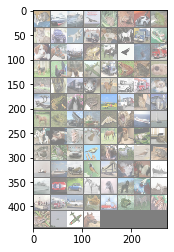

GroundTruth:    cat  ship  ship plane


In [13]:
# テストデータを取得
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像を表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
outputs = net(images.to(device))

In [15]:
_, predicted = torch.max(outputs.to(device), 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship  ship  ship


In [18]:
correct = 0
total = 0
with torch.no_grad():  #勾配計算をしない宣言(逆伝播用の計算グラフを作成しないことでメモリ節約、速度向上する)
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(
    round(100 * correct / total, 4)))

Accuracy of the network on the 10000 test images: 79.1 %


In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 88 %
Accuracy of   car : 90 %
Accuracy of  bird : 68 %
Accuracy of   cat : 51 %
Accuracy of  deer : 81 %
Accuracy of   dog : 78 %
Accuracy of  frog : 90 %
Accuracy of horse : 81 %
Accuracy of  ship : 89 %
Accuracy of truck : 82 %
